In [ ]:
import os

# Data Preproessing libraries
import pandas as pd
import numpy as np

# Data Visualisation libraries
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import time


# Model Evaluation libraries
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve

# Data resampling libraries
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Feature Scaling and Encoding libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Mount and load dataset from google drive
from google.colab import drive

# Tensorflow keras libraries for LSTM
! pip install keras-tuner --upgrade
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import load_model
from keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperModel
from keras.utils import plot_model

! pip install pydot
! pip install graphviz
# ! pip install pipreqs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## DEEP LEARNING LSTM IMPLEMENTATION

In [ ]:
clean_appointments_df = pd.read_csv("/content/drive/MyDrive/data/cleaned_medical_appointments.csv")

In [ ]:
clean_appointments_df

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no-show,weekday,waittime,appointmentcount
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,Friday,0,2
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,Friday,0,2
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,Friday,0,2
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,Friday,0,2
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,Friday,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106977,2.572134e+12,5651768,F,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,35,2
106978,3.596266e+12,5650093,F,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,35,4
106979,1.557663e+13,5630692,F,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,41,1
106980,9.213493e+13,5630323,F,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,41,2


In [ ]:
data_df = clean_appointments_df.copy()
columns = data_df.columns.to_list()
columns.remove('no-show')
columns.append('no-show')
data_df = data_df[columns]

### LSTM MODEL BUILDING
To prepare the dataset and build the LSTM model, the following utility functions are defined to make the process modular;
* Resample data function
* Load and preprocees data function 
* split data function
* Build deep LSTM function
* Plot Loss curves function
* Plot accuracy curves function
* Train and Evaluate function
* Evaluate Model performance function

In [ ]:
# Define a function that takes the original dataset and creates three rersampled datasets
def resample_data(df, target_column):
    # Drop columns with irrelevant types not suitable for sampling
    df = df.drop(columns=['appointmentday', 'appointmentid', 'scheduledday'])

    # Encode Categorical Variables
    le = LabelEncoder()
    df['gender'] = le.fit_transform(df['gender'])
    df['neighbourhood'] = le.fit_transform(df['neighbourhood'])
    df['weekday'] = le.fit_transform(df['weekday'])

    # Separate majority and minority classes
    majority_class = df[df[target_column] == 0]
    minority_class = df[df[target_column] == 1]

    # Upsample minority class
    minority_upsampled = resample(minority_class,
                                  replace=True,  # sample with replacement
                                  n_samples=len(majority_class),  # to match majority class
                                  random_state=42)  # reproducible results

    # Combine majority class with upsampled minority class
    upsampled_data = pd.concat([majority_class, minority_upsampled])

    # Downsample majority class
    majority_downsampled = resample(majority_class,
                                    replace=False,  # sample without replacement
                                    n_samples=len(minority_class),  # to match minority class
                                    random_state=42)  # reproducible results

    # Combine minority class with downsampled majority class
    downsampled_data = pd.concat([majority_downsampled, minority_class])

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X = df.drop(target_column, axis=1)  # Independent variables
    y = df[target_column]  # Dependent variable (no-show)
    X_res, y_res = sm.fit_resample(X, y)
    smote_data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=[target_column])], axis=1)

    print(f"Original Training Data Distribution: {data_df['no-show'].value_counts()} \n")
    print(f"Class Distribution in upsampled data: {upsampled_data['no-show'].value_counts()} \n")
    print(f"Class Distribution in downsampled data: {downsampled_data['no-show'].value_counts()} \n")
    print(f"Class Distribution in SMOTE data: {smote_data['no-show'].value_counts()} \n")

    return upsampled_data, downsampled_data, smote_data

# # Save resampled datasets
upsampled_data, downsampled_data, smote_data = resample_data(data_df, 'no-show')

# Create data frames from the resampled datasets
upsampled_data.to_csv("/content/drive/MyDrive/data/upsampled_appointments.csv", index=False)
downsampled_data.to_csv("/content/drive/MyDrive/data/downsampled_appointments.csv", index=False)
smote_data.to_csv("/content/drive/MyDrive/data/smotesampled_appointments.csv", index=False)



def load_and_preprocess_data(data, dataset_name):
    if dataset_name == 'original':
      data = data.drop(columns=['appointmentday', 'appointmentid', 'scheduledday'])
      le = LabelEncoder()
      data['gender'] = le.fit_transform(clean_appointments_df['gender'])
      data['neighbourhood'] = le.fit_transform(clean_appointments_df['neighbourhood'])
      data['weekday'] = le.fit_transform(clean_appointments_df['weekday'])

    # Normalize numerical columns
    scaler = StandardScaler()
    numerical_cols = ['age', 'waittime', 'appointmentcount']
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # One-hot encode categorical variables
    categorical_cols = ['gender', 'neighbourhood', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'weekday']
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(data[categorical_cols]).toarray()

    # Combine numerical and one-hot encoded features
    X = np.hstack((encoded_features, data[numerical_cols].values))
    y = data['no-show'].values

    # Reshape input for LSTM
    X = X.reshape(X.shape[0], 1, X.shape[1])

    return X, y

def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def build_deep_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape, activation='relu'),
        Dropout(0.2),
        LSTM(30, return_sequences=True, activation='relu'),
        Dropout(0.2),
        LSTM(20, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

def plot_loss_curves(history, dataset_name):
    """Plot the loss curves during training for a specific dataset."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves ({dataset_name} Dataset)')
    plt.legend()
    plt.savefig(f'{dataset_name}_loss_curves.png')
    plt.show()

def plot_accuracy_curves(history, dataset_name):
    """Plot the accuracy curves during training for a specific dataset."""
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)

    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curves ({dataset_name} Dataset)')
    plt.legend()
    plt.savefig(f'{dataset_name}_accuracy_curves.png')
    plt.show()


def train_and_evaluate(model, X_train, y_train, X_test, y_test, dataset_name):
    start_time = time.time()  # Start time of training

    # Define the directory for saving the models
    model_directory = '/content/drive/MyDrive/data/model_checkpoints'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)


    model_path = f'{model_directory}/best_model_{dataset_name}.h5'


    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=10,
        validation_data=(X_test, y_test),  # Use test data for validation
        callbacks=[checkpoint, early_stopping],
        verbose=2
    )

    # Calculate training time
    training_time = time.time() - start_time

    plot_loss_curves(history, dataset_name)
    plot_accuracy_curves(history, dataset_name)

    # Load the best model and evaluate using the test data
    loaded_model = load_model(model_path)
    _, test_accuracy = loaded_model.evaluate(X_test, y_test, verbose=1)
    train_accuracy = max(history.history['accuracy'])

    print(f"{dataset_name} - Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"{dataset_name} - Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"{dataset_name} - Training Time: {training_time:.2f} seconds")

    return loaded_model

def evaluate_model_performance(y_true, y_pred_prob, threshold=0.5):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_prob > threshold).astype(int)

    # Print classification report
    print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['No Show', 'Show']))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Show', 'Show'])
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {auc_pr:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

Original Training Data Distribution: no-show
0    85307
1    21675
Name: count, dtype: int64 

Class Distribution in upsampled data: no-show
0    85307
1    85307
Name: count, dtype: int64 

Class Distribution in downsampled data: no-show
0    21675
1    21675
Name: count, dtype: int64 

Class Distribution in SMOTE data: no-show
0    85307
1    85307
Name: count, dtype: int64 



#### TRAIN AND TEST LSTM MODEL
The LSTM model is trained and evaluated on the original dataset and all resampled datasets with the following evaluation metrics;

* Precision-Recall Curve: This curve shows the tradeoff between precision and recall for different threshold values. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. This metric is suitable for this use case because the classes are imbalanced. <br>

* Confusion Matrix: A confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known. It shows the number of correct and incorrect predictions made by the model compared to the actual classifications in the data. The matrix itself is divided into four parts: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN), which help in further analysis of the model’s performance. <br>

* ROC Curve: The Receiver Operating Characteristic curve is a graphical plot that illustrates the diagnostic ability of a lassifier to distinguish between two classes as its discrimination threshold is varied. It plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The area under the curve (AUC) represents the model's ability to correctly classify the positives and negatives (no-show or show). <br>

* Classification Report: This is a performance evaluation metric that displays the precision, recall and F1-score for each class. The report helps in assessing the effectiveness of the classification model, particularly:
    * Precision: Measures the accuracy of positive predictions.
    * Recall: Measures the ability of the model to find all the relevant cases (all actual positives).
    * F1-Score: Provides a balance between precision and recall, useful when the classes are unevenly distributed.



Processing original dataset...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.45571, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_original.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8559/8559 - 39s - loss: 0.4664 - accuracy: 0.7974 - val_loss: 0.4557 - val_accuracy: 0.7974 - 39s/epoch - 5ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.45571 to 0.44978, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_original.h5
8559/8559 - 35s - loss: 0.4537 - accuracy: 0.7974 - val_loss: 0.4498 - val_accuracy: 0.7974 - 35s/epoch - 4ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.44978 to 0.44641, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_original.h5
8559/8559 - 35s - loss: 0.4488 - accuracy: 0.7974 - val_loss: 0.4464 - val_accuracy: 0.7974 - 35s/epoch - 4ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.44641 to 0.44341, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_original.h5
8559/8559 - 35s - loss: 0.4467 - accuracy: 0.7974 - val_loss: 0.4434 - val_accuracy: 0.7974 - 35s/epoch - 4ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.44341 to 0.44259, saving model to /content/driv

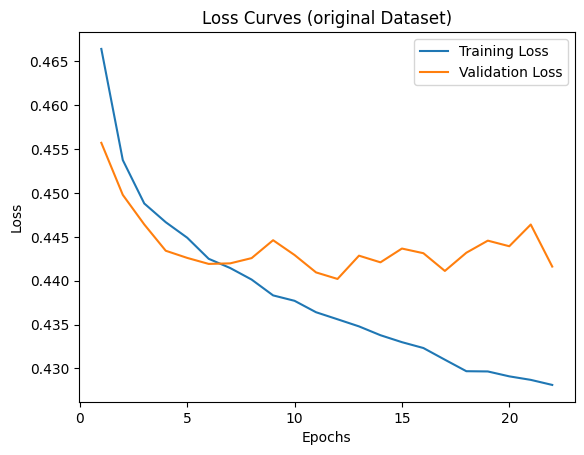

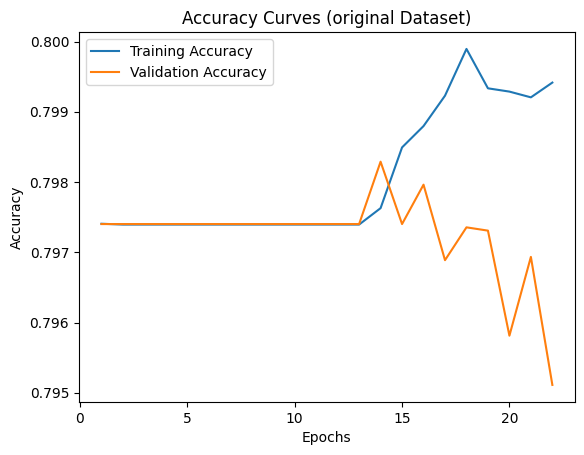

669/669 [==============================] - 3s 3ms/step - loss: 0.4402 - accuracy: 0.7974
original - Train Accuracy: 79.99%
original - Test Accuracy: 79.74%
original - Training Time: 751.87 seconds
669/669 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

     No Show       0.80      1.00      0.89     17062
        Show       0.00      0.00      0.00      4335

    accuracy                           0.80     21397
   macro avg       0.40      0.50      0.44     21397
weighted avg       0.64      0.80      0.71     21397



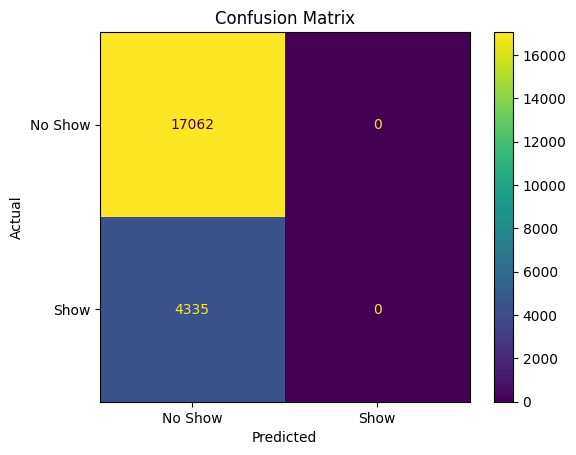

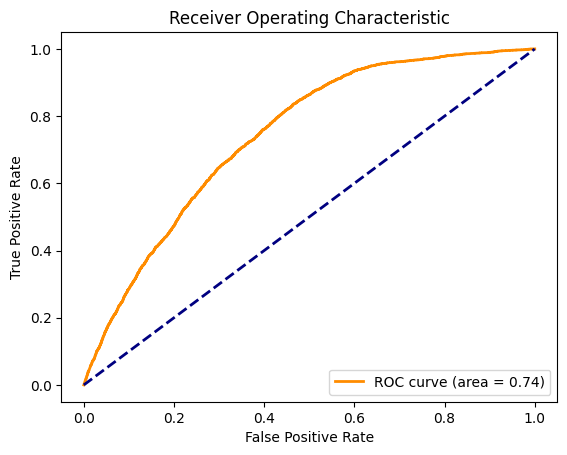

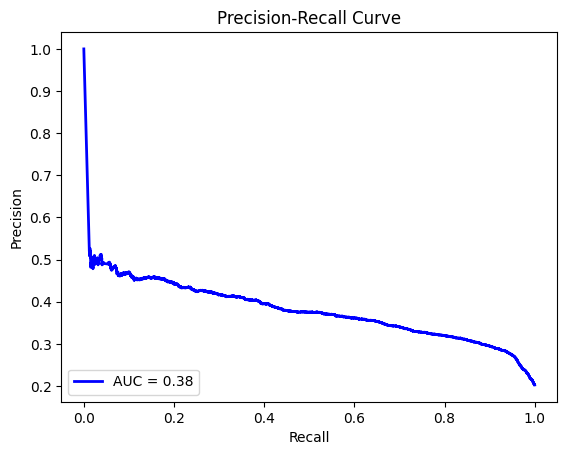

Processing upsampled dataset...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.59580, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_upsampled.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13650/13650 - 60s - loss: 0.6160 - accuracy: 0.6599 - val_loss: 0.5958 - val_accuracy: 0.6734 - 60s/epoch - 4ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.59580 to 0.59210, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_upsampled.h5
13650/13650 - 58s - loss: 0.5959 - accuracy: 0.6742 - val_loss: 0.5921 - val_accuracy: 0.6795 - 58s/epoch - 4ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.59210 to 0.58541, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_upsampled.h5
13650/13650 - 59s - loss: 0.5875 - accuracy: 0.6818 - val_loss: 0.5854 - val_accuracy: 0.6796 - 59s/epoch - 4ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.58541 to 0.58304, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_upsampled.h5
13650/13650 - 54s - loss: 0.5835 - accuracy: 0.6845 - val_loss: 0.5830 - val_accuracy: 0.6858 - 54s/epoch - 4ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.58304 to 0.57725, saving model to /c

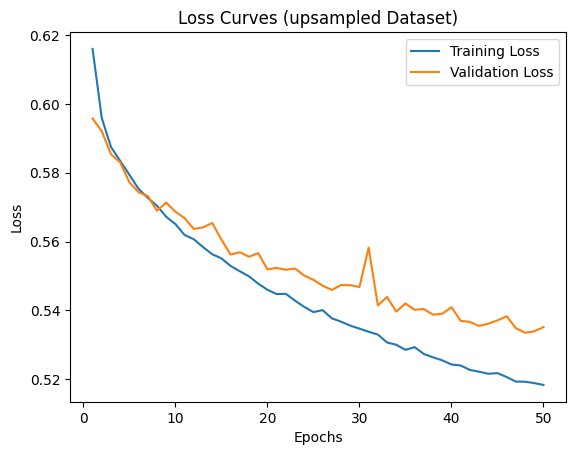

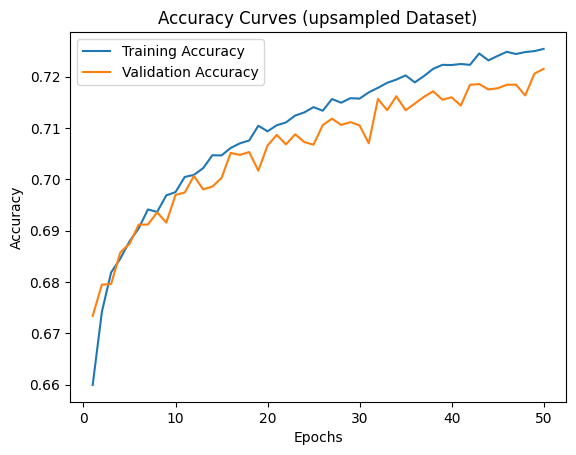

1067/1067 [==============================] - 3s 2ms/step - loss: 0.5335 - accuracy: 0.7163
upsampled - Train Accuracy: 72.54%
upsampled - Test Accuracy: 71.63%
upsampled - Training Time: 2806.92 seconds
1067/1067 [==============================] - 3s 2ms/step
Classification Report:
               precision    recall  f1-score   support

     No Show       0.76      0.63      0.69     17062
        Show       0.69      0.80      0.74     17061

    accuracy                           0.72     34123
   macro avg       0.72      0.72      0.71     34123
weighted avg       0.72      0.72      0.71     34123



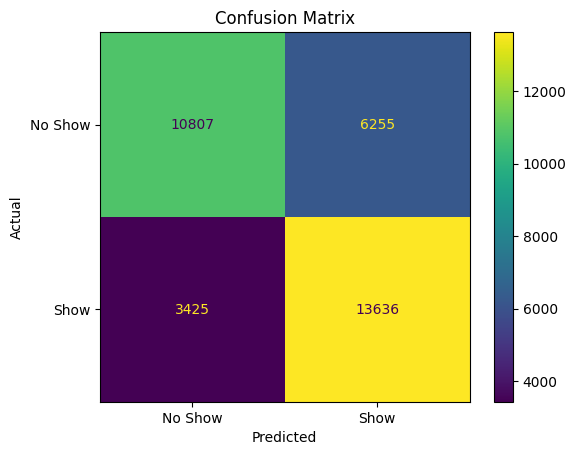

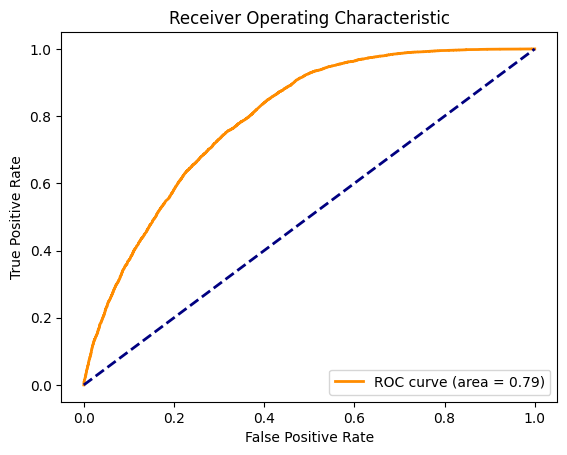

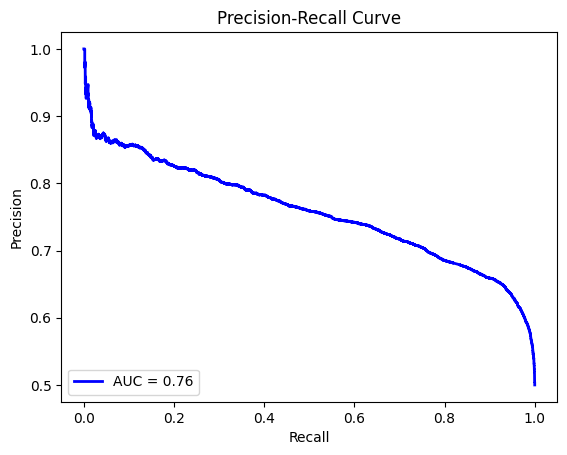

Processing downsampled dataset...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.61560, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_downsampled.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3468/3468 - 18s - loss: 0.6404 - accuracy: 0.6390 - val_loss: 0.6156 - val_accuracy: 0.6552 - 18s/epoch - 5ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.61560 to 0.60951, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_downsampled.h5
3468/3468 - 13s - loss: 0.6174 - accuracy: 0.6589 - val_loss: 0.6095 - val_accuracy: 0.6623 - 13s/epoch - 4ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.60951 to 0.60682, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_downsampled.h5
3468/3468 - 13s - loss: 0.6088 - accuracy: 0.6660 - val_loss: 0.6068 - val_accuracy: 0.6720 - 13s/epoch - 4ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.60682 to 0.59885, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_downsampled.h5
3468/3468 - 17s - loss: 0.6044 - accuracy: 0.6679 - val_loss: 0.5989 - val_accuracy: 0.6732 - 17s/epoch - 5ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.59885 to 0.59697, saving model to /con

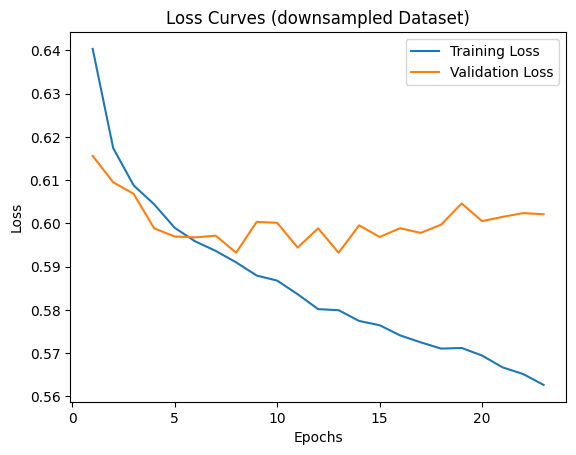

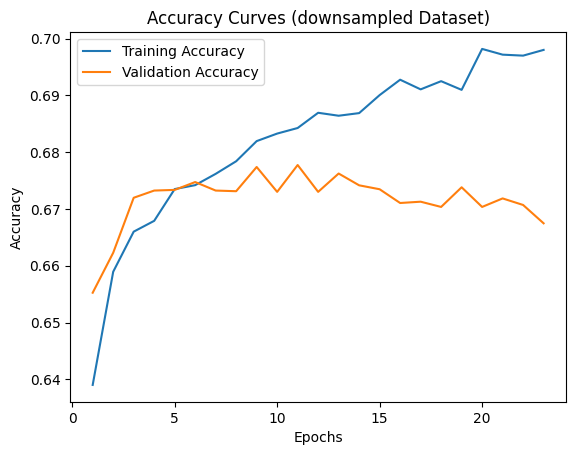

271/271 [==============================] - 1s 2ms/step - loss: 0.5932 - accuracy: 0.6762
downsampled - Train Accuracy: 69.82%
downsampled - Test Accuracy: 67.62%
downsampled - Training Time: 299.88 seconds
271/271 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

     No Show       0.73      0.56      0.64      4335
        Show       0.64      0.79      0.71      4335

    accuracy                           0.68      8670
   macro avg       0.69      0.68      0.67      8670
weighted avg       0.69      0.68      0.67      8670



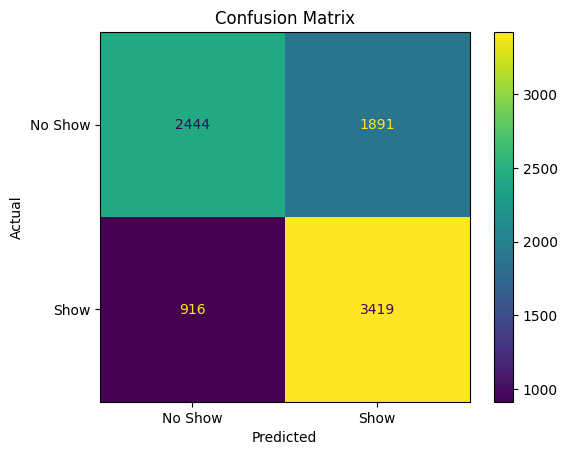

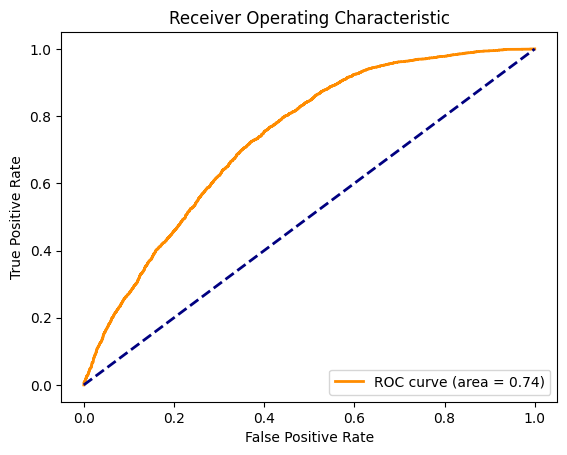

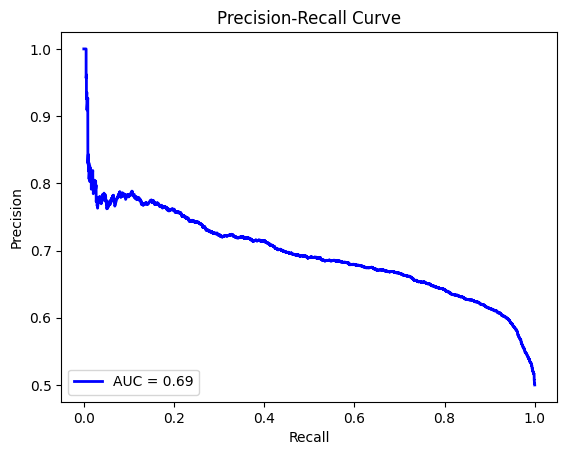

Processing smote dataset...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.47034, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_smote.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13650/13650 - 59s - loss: 0.4966 - accuracy: 0.7512 - val_loss: 0.4703 - val_accuracy: 0.7663 - 59s/epoch - 4ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.47034 to 0.46535, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_smote.h5
13650/13650 - 55s - loss: 0.4721 - accuracy: 0.7676 - val_loss: 0.4654 - val_accuracy: 0.7689 - 55s/epoch - 4ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.46535 to 0.46045, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_smote.h5
13650/13650 - 59s - loss: 0.4647 - accuracy: 0.7711 - val_loss: 0.4605 - val_accuracy: 0.7722 - 59s/epoch - 4ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.46045 to 0.45568, saving model to /content/drive/MyDrive/data/model_checkpoints/best_model_smote.h5
13650/13650 - 54s - loss: 0.4596 - accuracy: 0.7736 - val_loss: 0.4557 - val_accuracy: 0.7722 - 54s/epoch - 4ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.45568 to 0.45466, saving model to /content/drive

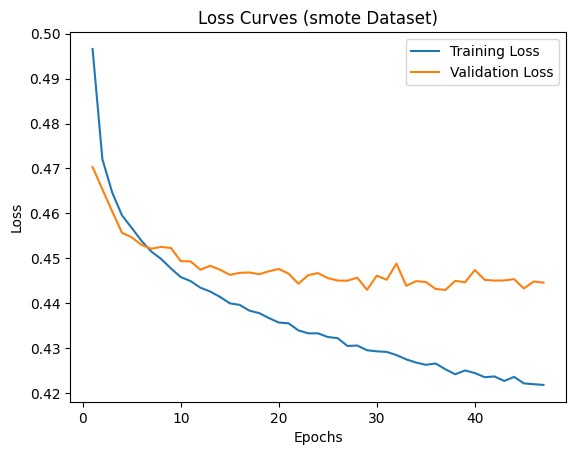

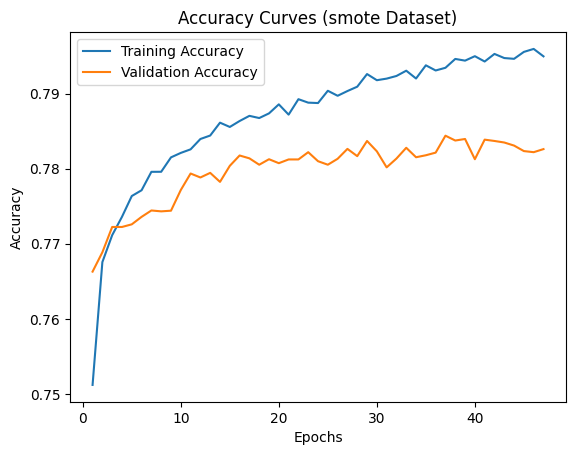

1067/1067 [==============================] - 3s 2ms/step - loss: 0.4430 - accuracy: 0.7844
smote - Train Accuracy: 79.60%
smote - Test Accuracy: 78.44%
smote - Training Time: 2652.46 seconds
1067/1067 [==============================] - 4s 3ms/step
Classification Report:
               precision    recall  f1-score   support

     No Show       0.76      0.82      0.79     17062
        Show       0.81      0.75      0.78     17061

    accuracy                           0.78     34123
   macro avg       0.79      0.78      0.78     34123
weighted avg       0.79      0.78      0.78     34123



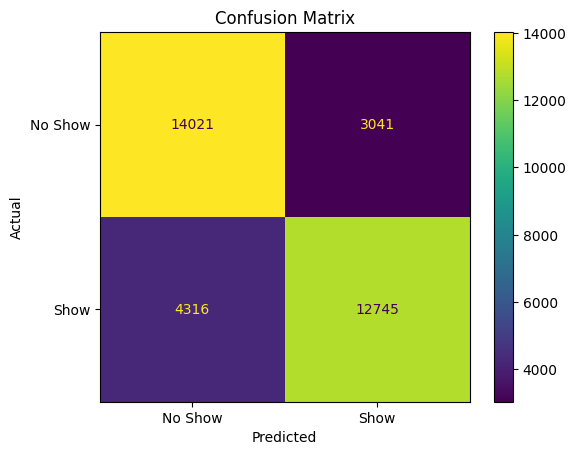

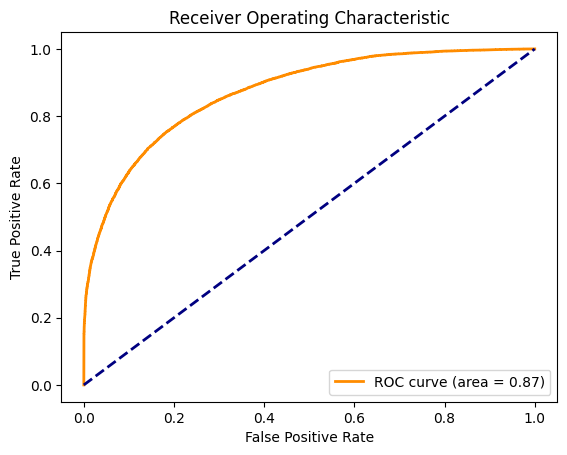

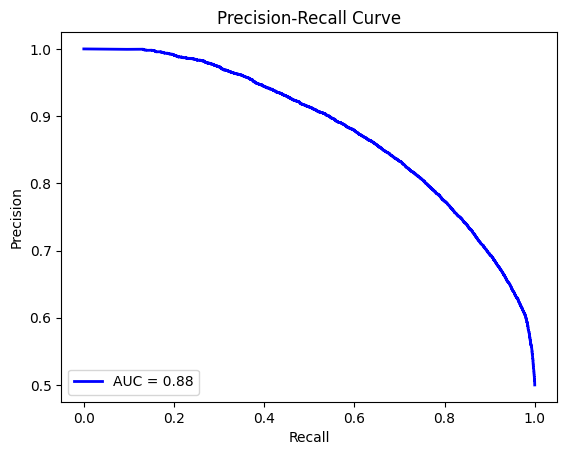

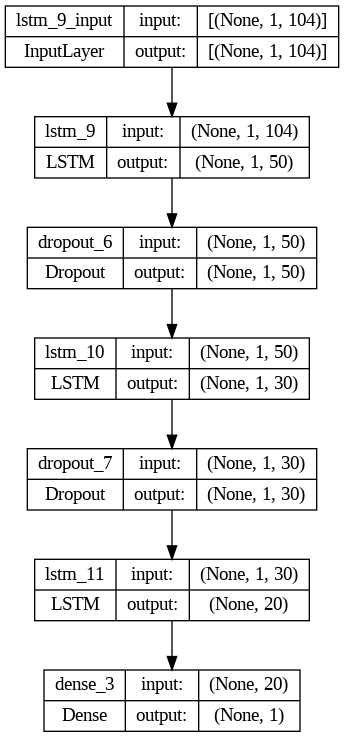

In [ ]:
datasets = {
    'original': data_df,
    'upsampled': upsampled_data,
    'downsampled': downsampled_data,
    'smote': smote_data
}

for name, dataframe in datasets.items():
    print(f"Processing {name} dataset...")
    X, y = load_and_preprocess_data(dataframe, name)
    X_train, X_test, y_train, y_test = split_data(X, y)
    model = build_deep_lstm_model((X_train.shape[1], X_train.shape[2]))
    trained_model = train_and_evaluate(model, X_train, y_train, X_test, y_test, name)


    # Evaluate the model with the evaluation metrics
    y_pred_prob = trained_model.predict(X_test)
    evaluate_model_performance(y_test, y_pred_prob)

 # Show Image of LSTM Model Architecture
plot_model(model,
        to_file='model.png',
        show_shapes=True,
        show_layer_names=True
    )


#### LSTM HYPERMODEL
To improve the model's performance, the following hyperparameters are tuned using the Keras Tuner library; 
* Number of LSTM layers
* Number of LSTM units
* Dropout rate
* Learning rate
* Optimizer

The hypermodel is built using the Keras Tuner library and the best hyperparameters are selected. The model is trained and evaluated using the same evaluation metrics as the original untuned model.

In [ ]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        # First LSTM layer with possibility to return sequences
        model.add(LSTM(
            units=hp.Int('units1', min_value=50, max_value=256, step=10),
            return_sequences=True,
            input_shape=self.input_shape,
            activation='relu'
        ))

        # Add the First Dropout Layer
        model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))

        # Add Second LSTM layer with return sequences
        model.add(LSTM(
            units=hp.Int('units2', min_value=30, max_value=150, step=10),
            return_sequences=True,
            activation='relu'
        ))
        # Add the secnd Droupout Layer
        model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))

        # Add the Third LSTM layer with no return sequences
        model.add(LSTM(
            units=hp.Int('units3', min_value=20, max_value=100, step=10),
            activation='relu'
        ))

        # Add the Output Binary Classification layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

def train_and_evaluate_hypermodel(hypermodel, X_train, y_train, X_test, y_test, num_trials=5):
    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=num_trials,
        executions_per_trial=2,
        directory='/content/drive/MyDrive/data/hypermodel_tuning',
        project_name='AppointmentNoShow'
    )

    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Evaluate best model
    _, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"Best Hypermodel Test Accuracy: {test_accuracy * 100:.2f}%")

    # Print the best hyperparameters
    print("Best Hyperparameters:")
    for param, value in best_hyperparameters.values.items():
        print(f"{param}: {value}")

    return best_model


Trial 5 Complete [01h 41m 53s]
val_accuracy: 0.7831081748008728

Best val_accuracy So Far: 0.7866981029510498
Total elapsed time: 05h 30m 58s
1067/1067 [==============================] - 6s 4ms/step - loss: 0.4411 - accuracy: 0.7868
Best Hypermodel Test Accuracy: 78.68%
Best Hyperparameters:
units1: 180
dropout1: 0.30000000000000004
units2: 60
dropout2: 0.30000000000000004
units3: 20
learning_rate: 0.001
Training and evaluation completed on SMOTE dataset.
1067/1067 [==============================] - 5s 4ms/step
Classification Report:
               precision    recall  f1-score   support

     No Show       0.77      0.82      0.79     17062
        Show       0.80      0.76      0.78     17061

    accuracy                           0.79     34123
   macro avg       0.79      0.79      0.79     34123
weighted avg       0.79      0.79      0.79     34123



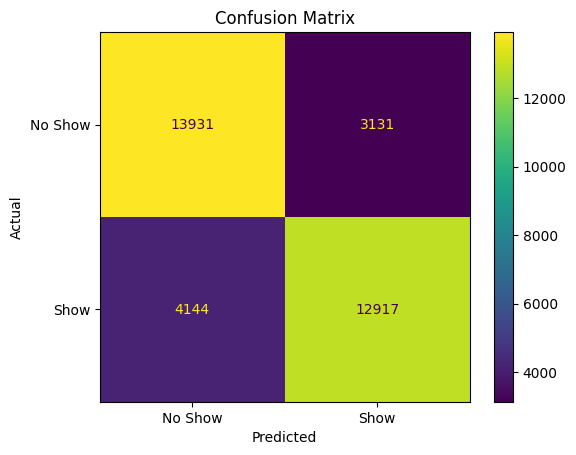

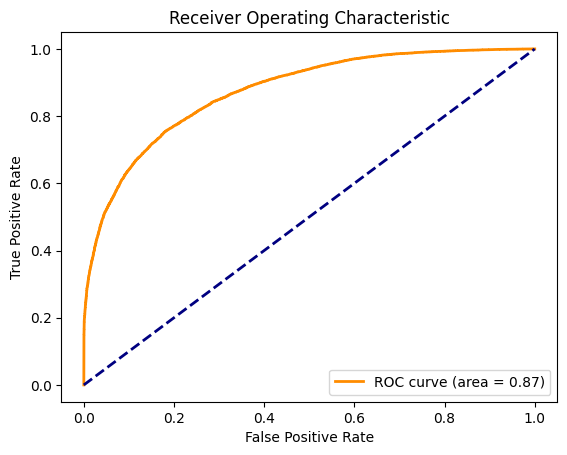

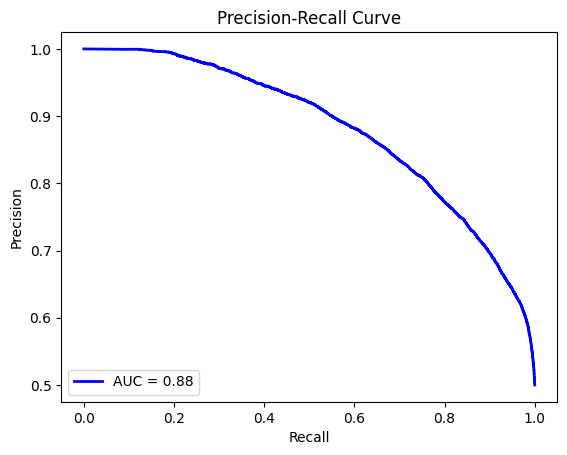

In [ ]:
# Preprocess the data specifically for the SMOTE dataset
X_smote, y_smote = load_and_preprocess_data(smote_data, 'smote')

# Split the data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = split_data(X_smote, y_smote)

# Define the input shape for the HyperModel
input_shape = (X_train_smote.shape[1], X_train_smote.shape[2])

# Create an instance of the LSTMHyperModel
hypermodel = LSTMHyperModel(input_shape=input_shape)

# Train and evaluate hypermodel
best_model_smote = train_and_evaluate_hypermodel(hypermodel, X_train_smote, y_train_smote, X_test_smote, y_test_smote, num_trials=5)

# Output the results
print("Training and evaluation completed on SMOTE dataset.")


# Evaluate the model with the evaluation metrics
y_pred_prob_smote = best_model_smote.predict(X_test_smote)
evaluate_model_performance(y_test_smote, y_pred_prob_smote)